In [1]:
-- Code for Wide Residual Networks http://arxiv.org/abs/1605.07146
-- (c) Sergey Zagoruyko, 2016
require 'xlua'
require 'optim'
require 'image'
require 'cunn'
require 'cudnn'
c = require 'trepl.colorize'
json = require 'cjson'
require'augmentation'
model_utils = require 'model_utils'   ---sjmod
require'provider'
require'nngraph'
require 'csvigo'

-- for memory optimizations and graph generation
local optnet = require 'optnet'
local graphgen = require 'optnet.graphgen'
local iterm = require 'iterm'
require 'iterm.dot'

opt = {
  save = 'logs_vgg-gap100/',
  batchSize = 64, --128,
  learningRate = 0.1,   ------overwritten
  learningRateDecay = 0,   ------overwritten
  learningRateDecayRatio = 0.2,   ------overwritten
  weightDecay = 0.0005,
  dampening = 0,
  momentum = 0.9,
  epoch_step = "80",   ------overwritten
  max_epoch = 300,   ------overwritten

  model = 'model.t7',

  optimMethod = 'sgd',
  init_value = 10,
  depth = 50,
  shortcutType = 'A',
  nesterov = false,   ------overwritten
  dropout = 0,
  hflip = true,
  randomcrop = 4,
  imageSize = 32,
  randomcrop_type = 'zero',   ------overwritten
  cudnn_fastest = true,
  cudnn_deterministic = false,
  optnet_optimize = true,
  generate_graph = false,
  multiply_input_factor = 1,
  widen_factor = 1,
}
opt = xlua.envparams(opt)

opt.epoch_step = tonumber(opt.epoch_step) or loadstring('return '..opt.epoch_step)()
--print(opt)


==> loading data	


 1
[torch.DoubleTensor of size 1]



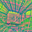

In [2]:
print(c.blue '==>' ..' loading data')
--provider = torch.load('/media/sjvision/DATASETDISK/cifars/cifar100/cifar100_whitened.t7')
--provider = torch.load('/media/sjvision/DATASETDISK/ObjectDiscovery-data/ach_100/t7_files/objDiscoData_ach_whitened.t7')
provider = torch.load('/media/sjvision/DATASETDISK/Attention_extra_data/data_processed/IndoorSceneRecognition67/t7_files/indoorscenereco67_norm.t7')
print(provider.testData.labels[400])
itorch.image(provider.testData.data[400])

In [3]:
print(c.blue '==>' ..' configuring models')
model = nn.Sequential()
net = torch.load('/media/sjvision/01D007501C4F6DD0/2_Codes/TorchCodes/attention_business/ActiveAttention/RESNET/#results/vgg_gap_cifar100_14355834/' ..opt.model):cuda()

==> configuring models	


In [4]:
do
   ------Main Model----------INITIALIZATION-----------------
   model:add(nn.Copy('torch.FloatTensor','torch.CudaTensor'):cuda())   
   model:add(net) -- adding the network -- sjmod
end

In [5]:
print(model:get(2):get(51))

nn.View(512)
{
  train : false
  output : CudaTensor - empty
  gradInput : CudaTensor - empty
  size : LongStorage - size: 1
  numElements : 512
  _type : torch.CudaTensor
}


In [6]:
function test()
  
    model:evaluate()
    --local confusion = optim.ConfusionMatrix(100)
    nsamples = provider.testData.data:size(1)
    bs = 1 print(nsamples)
    fv_output = torch.zeros(nsamples,512)
    
  for i = 1,nsamples,bs do 
        local pred = model:forward(provider.testData.data:narrow(1,i,bs))
        pred = pred:reshape(1,100)
        fv_output[i] = model:get(2):get(51).output:squeeze():float()
        --[[
        val, ind = torch.max(pred,2)
        print(ind)
        print(provider.testData.labels[i])       
        confusion:batchAdd(pred, provider.testData.labels:narrow(1,i,bs))   ---testing fwd   ---sjmod
        confusion:updateValids()
        --]]
  end
    fv_output = fv_output:totable()
    csvigo.save('logs_vgg-gap100/vgg_gap100_saction40.txt',fv_output)
  return 0 --confusion.totalValid * 100
    
end


In [7]:
function extract_attmaps()
  
    model:evaluate()  
    nsamples = provider.testData.data:size(1)
    bs = 1 print(nsamples)
        
  for i = 101,200,bs do 
        -- fwd prop through the entire network pipeline
        local pred = model:forward(provider.testData.data:narrow(1,i,bs))
        -- extract the 3D tensor before GAP
        local spatialtensor = model:get(2):get(49).output:squeeze()
        -- extract the weight vector for the corresponding class
        local classid
        if i<=100 then -- airplane - not present - cant work for the classes not trained for
        elseif i<=200 then
            classid = 82
        else -- horse - not present - cant work for the classes not trained for
        end
        local classwtvec = model:get(2):get(52):get(1).weight[classid]:squeeze()
        classwtvec = nn.Replicate(8,2,1):cuda():forward(classwtvec)
        classwtvec = nn.Replicate(8,2,1):cuda():forward(classwtvec)
        -- obtain the attmaps as the dot product at each spatial location in the 3D tensor
        local att_map = nn.CMulTable():cuda():forward({spatialtensor,classwtvec})
        att_map = nn.Sum(1,3):cuda():forward(att_map)
        -- save the attmap
        att_map = att_map:totable()
        csvigo.save(string.format('/media/sjvision/DATASETDISK/ObjectDiscovery-data/ach_100/VGG-GAP_100/att_maps_raw/%03d_%s',i,'level2.txt'),att_map)
  end

  return
    
end

In [8]:
for epoch=1,1 do
  local test_acc, test_time =test()  ----sjmod
  --extract_attmaps()
end

15613	


<csv>	writing to file: logs_vgg-gap100/vgg_gap100_saction40.txt	


<csv>	writing done	
